# Canonical SC protocols. For version 0.2.1

## Simplified setup

![title](canonical_setup.png)

## Code

Note: All the code was tested on the simulator of gateway version 0.2.1, agent version 0.1.4, QM App version 0.1.4

### Import relevant python packages

In [10]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from qm import SimulationConfig
from qm import LoopbackInterface
import matplotlib.pyplot as plt
import numpy as np
import time

### Open communication with the server.

In [11]:
QMm = QuantumMachinesManager()

2020-04-03 11:46:57,567 - qm - INFO - Preforming health check
2020-04-03 11:46:57,580 - qm - INFO - Health check passed


### Helper functions

In [12]:
def gauss(amplitude, mu, sigma, length):
    t = np.linspace(-length/2, length/2, length)
    gauss_wave = amplitude * np.exp(-((t-mu)**2)/(2*sigma**2))
    return [float(x) for x in gauss_wave]

def IQ_imbalance_corr(g, phi):
    c = np.cos(phi)
    s = np.sin(phi)
    N = 1 / ((1 - g**2) * (2 * c**2 - 1))
    return [float(N * x) for x in [(1 - g) * c, (1 + g) * s,
                                   (1 - g) * s, (1 + g) * c]]
def find_waits(v):
    waits = []
    counter = 0
    for v_ in v:
        if v_ == 0:
            counter += 1
        elif v_!=0 and counter!=0:
            waits.append(counter)
            counter = 0
        else:
            counter = 0
    return waits 

### The configuration

In [13]:
config = {

    'version': 1,

    'controllers': {

        'con1': {
            'type': 'opx1',
            'analog_outputs': {
                1: {'offset': 0.0},          # I1
                2: {'offset': 0.0},          # Q1
                3: {'offset': 0.0},          # I2
                4: {'offset': 0.0},          # Q2
                5: {'offset': 0.0},          # Fast_Flux1
                6: {'offset': 0.0},          # Fast_Flux2
                7: {'offset': 0.0},          # RR1, RR2
            },
            'digital_outputs': {},
            'analog_inputs': {
                1: {'offset': 0.0},          # RR1, RR2
            }
        }
    },
    
    'elements': {
        
        # Those are the "quantum elements" in the setup. We are thinking of
        # each element as a "black box" with inputs from the OPX and outputs to the OPX.
        
        'qubit1': {
            'mixInputs': {
                'I': ('con1', 1),
                'Q': ('con1', 2),
                'lo_frequency': 4e9,
                'mixer': 'mixer1'
            },
            'intermediate_frequency': 50e6,
            'operations': {
                'saturation': 'saturation_pulse',
                'gaussian': 'gaussian_pulse',
                'pi': 'pi_pulse1',
                'pi/2': 'pi/2_pulse1'
            },   
        },
        
        'qubit2': {
            'mixInputs': {
                'I': ('con1', 3),
                'Q': ('con1', 4),
                'lo_frequency': 5.5e9,
                'mixer': 'mixer2'
            },
            'intermediate_frequency': 38.22e6,
            'operations': {
                'saturation': 'saturation_pulse',
                'gaussian': 'gaussian_pulse',
                'pi': 'pi_pulse2',
                'pi/2': 'pi/2_pulse2',
            },   
        },
        
        "fast_flux1": {
            "singleInput": {
                "port": ("con1", 5)
            },
            'operations': {
                'flux_bias': 'flux_bias1'
            }
        },
        
        "fast_flux2": {
            "singleInput": {
                "port": ("con1", 6)
            },
            'operations': {
                'flux_bias': 'flux_bias2'
            }
        },
        
        'RR1': {
            "singleInput": {
                "port": ("con1", 7)
            },
            'intermediate_frequency': 20e6,
            'operations': {
                'readout': 'readout_pulse1',
            },
            "outputs": {
                'out1': ('con1', 1)
            },
            'time_of_flight': 80,
            'smearing': 0
        },
        
        'RR2': {
            "singleInput": {
                "port": ("con1", 7)
            },
            'intermediate_frequency': 160e6,
            'operations': {
                'readout': 'readout_pulse2',
            },
            "outputs": {
                'out1': ('con1', 1)
            },
            'time_of_flight': 80,
            'smearing': 0
        },
    },
    
    'pulses': {
        
        'saturation_pulse': {
            'operation': 'control',
            'length': 500,
            'waveforms': {
                'I': 'saturation_wf',
                'Q': 'zero_wf'
            }
        },
        
        'gaussian_pulse': {
            'operation': 'control',
            'length': 60,
            'waveforms': {
                'I': 'gauss_wf',
                'Q': 'zero_wf'
            } 
        },
        
        'pi_pulse1': {
            'operation': 'control',
            'length': 60,
            'waveforms': {
                'I': 'pi_wf1',
                'Q': 'zero_wf'
            }
        },
        
        'pi/2_pulse1': {
            'operation': 'control',
            'length': 60,
            'waveforms': {
                'I': 'pi/2_wf1',
                'Q': 'zero_wf'
            }
        },
        
        'pi_pulse2': {
            'operation': 'control',
            'length': 60,
            'waveforms': {
                'I': 'pi_wf2',
                'Q': 'zero_wf'
            }
        },
        
        'pi/2_pulse2': {
            'operation': 'control',
            'length': 60,
            'waveforms': {
                'I': 'pi/2_wf2',
                'Q': 'zero_wf'
            }
        },
        
        'flux_bias1': {
            'operation': 'control',
            'length': 1000,
            'waveforms': {
                'single': 'flux_wf1'
            }  
        },
        
        'flux_bias2': {
            'operation': 'control',
            'length': 1000,
            'waveforms': {
                'single': 'flux_wf2'
            }  
        },
        
        'readout_pulse1': {
            'operation': 'measurement',
            'length': 400,
            'waveforms': {
                'single': 'readout_wf1'
            },
            'integration_weights': {
                'Wc': 'Wc',
                'Ws': 'Ws',
                'WI_opt': 'WI_opt1',
                'WQ_opt': 'WQ_opt1'
            },
            'digital_marker': 'ON'
        },

        'readout_pulse2': {
            'operation': 'measurement',
            'length': 400,
            'waveforms': {
                'single': 'readout_wf2'
            },
            'integration_weights': {
                'Wc': 'Wc',
                'Ws': 'Ws',
                'WI_opt': 'WI_opt2',
                'WQ_opt': 'WQ_opt2'
            },
            'digital_marker': 'ON'
        },
    },
   
    'waveforms': {
        
        'saturation_wf': {
            'type': 'constant',
            'sample': 0.3
        },
        
        'zero_wf': {
            'type': 'constant',
            'sample': 0.0
        },
        
        'gauss_wf': {
            'type': 'arbitrary',
            'samples': gauss(0.4, 0.0, 10, 60)
        },
        
        'pi_wf1': {
            'type': 'arbitrary',
            'samples': gauss(0.2, 0.0, 10, 60)
        },
        
        'pi/2_wf1': {
            'type': 'arbitrary',
            'samples': gauss(0.1, 0.0, 10, 60)
        },
        
        'pi_wf2': {
            'type': 'arbitrary',
            'samples': gauss(0.22, 0.0, 10, 60)
        },
        
        'pi/2_wf2': {
            'type': 'arbitrary',
            'samples': gauss(0.11, 0.0, 10, 60)
        },
        
        'flux_wf1': {
            'type': 'constant',
            'sample': 0.3
        },
        
        'flux_wf2': {
            'type': 'constant',
            'sample': 0.32
        },
        
        'readout_wf1': {
            'type': 'constant',
            'sample': 0.08
        },
    
        'readout_wf2': {
            'type': 'constant',
            'sample': 0.09
        }
    },
    
    'digital_waveforms': {
        'ON': {
            'samples': [(1, 0)]
        }
    },
        
    'integration_weights': {
        
        'Wc': {
            'cosine': [1.0] * int(400/4),
            'sine': [0.0] * int(400/4),
        },
        
        'Ws': {
            'cosine': [0.0] * int(400/4),
            'sine': [1.0] * int(400/4),
        },
        
        'WI_opt1': {
            'cosine': [1.0] * int(400/4),
            'sine': [0.0] * int(400/4),
        },
        
        'WQ_opt1': {
            'cosine': [0.0] * int(400/4),
            'sine': [1.0] * int(400/4),
        },
        
        'WI_opt2': {
            'cosine': [1.0] * int(400/4),
            'sine': [0.0] * int(400/4),
        },
        
        'WQ_opt2': {
            'cosine': [0.0] * int(400/4), 
            'sine': [1.0] * int(400/4),
        }
    },
    
    'mixers': {
        
        'mixer1': [
            {'intermediate_frequency': 50e6, 'lo_frequency': 4e9,
             'correction': IQ_imbalance_corr(0.0, 0.0 * np.pi)}
        ],

        'mixer2': [
            {'intermediate_frequency': 38.22e6, 'lo_frequency': 5.5e9,
             'correction': IQ_imbalance_corr(0.0, 0.0 * np.pi)}
        ], 
    }
}   

### opening quantum machine on the server based on the configuration:

In [14]:
qm = QMm.open_qm(config)

### QUA protocols:

#### Qubit spectroscopy:

In [15]:
with program() as qubit_spec:
    
    n = declare(int)
    f = declare(int)
    I = declare(fixed)
    
    with for_(n, 0, n<2, n+1):
 
        with for_(f, 10e6, f < 40e6, f + 10e6):
            
            update_frequency('qubit1', f)
            wait(200, 'qubit1')
            play('saturation', 'qubit1')
            align('qubit1', 'RR1')
            measure('readout', 'RR1', None, demod.full('Wc', I))
            save(I, 'I')

##### Test code:

2020-04-03 11:46:57,668 - qm - INFO - Flags: 
2020-04-03 11:46:57,669 - qm - INFO - Executing high level program


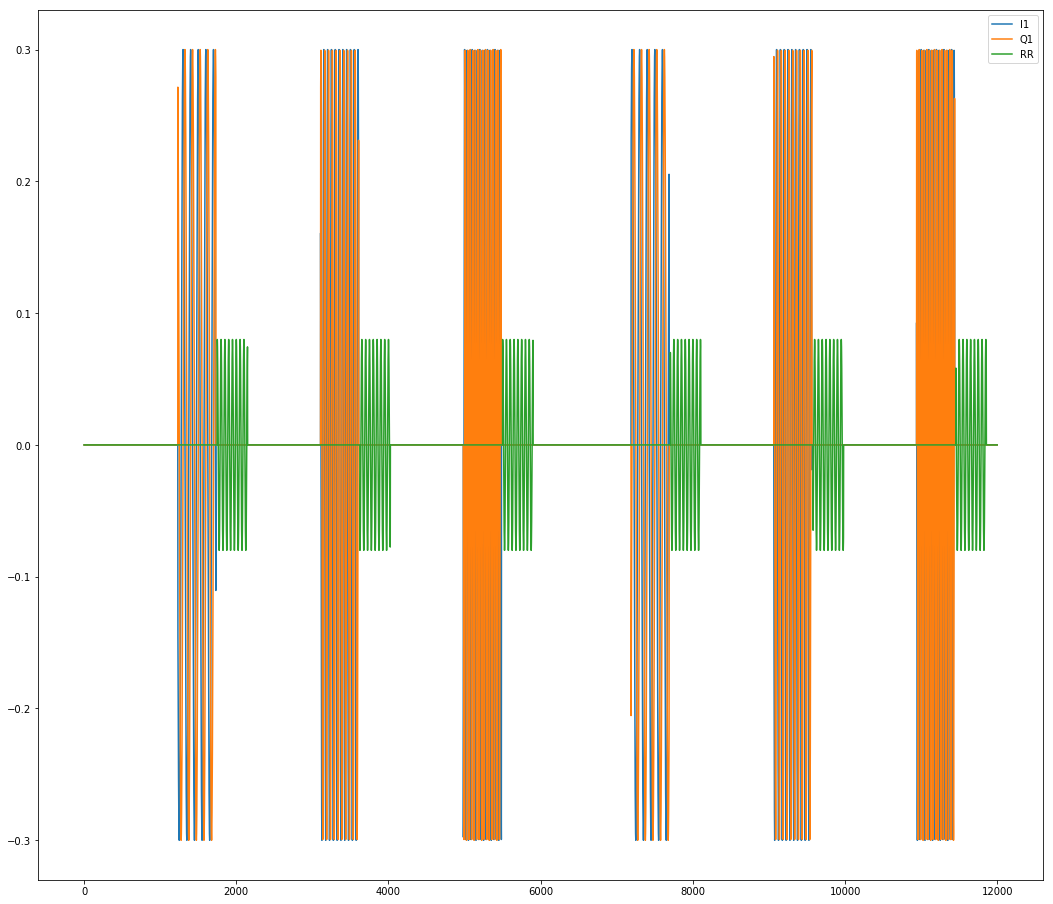

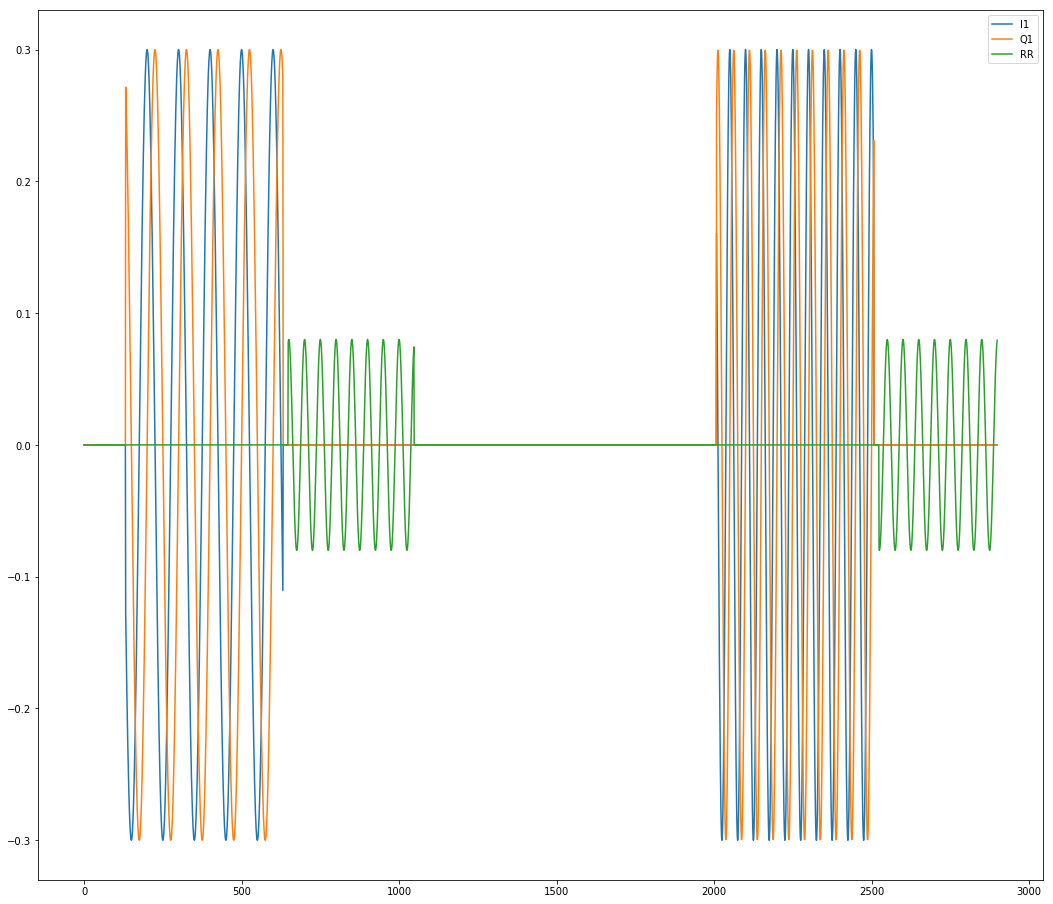

In [16]:
simConfigObj = SimulationConfig(3000)
job = qm.simulate(qubit_spec, simConfigObj)
samples = job.get_simulated_samples()
I1 = samples.con1.analog['1']
Q1 = samples.con1.analog['2']
RR = samples.con1.analog['7']

# plot 1
plt.figure(figsize=(18, 16))
plt.plot(I1, label='I1')
plt.plot(Q1, label='Q1')
plt.plot(RR, label='RR')
plt.legend()

# plot 2
plt.figure(figsize=(18, 16))
plt.plot(I1[1100:4000], label='I1')
plt.plot(Q1[1100:4000], label='Q1')
plt.plot(RR[1100:4000], label='RR')
plt.legend()

#### Power Rabi:

In [17]:
with program() as power_rabi:
    
    n = declare(int)
    a = declare(fixed)
    I = declare(fixed)
    
    with for_(n, 0, n<2, n+1):
        
        with for_(a, 0.1, a < 1, a + 0.3):
            
            wait(100, 'qubit1')
            play('gaussian' * amp(a), 'qubit1')
            align('qubit1', 'RR1')
            measure('readout', 'RR1', None, demod.full('Wc', I))
            save(I, 'I')
 
           

##### Test code: 

2020-04-03 11:46:58,885 - qm - INFO - Flags: 
2020-04-03 11:46:58,886 - qm - INFO - Executing high level program


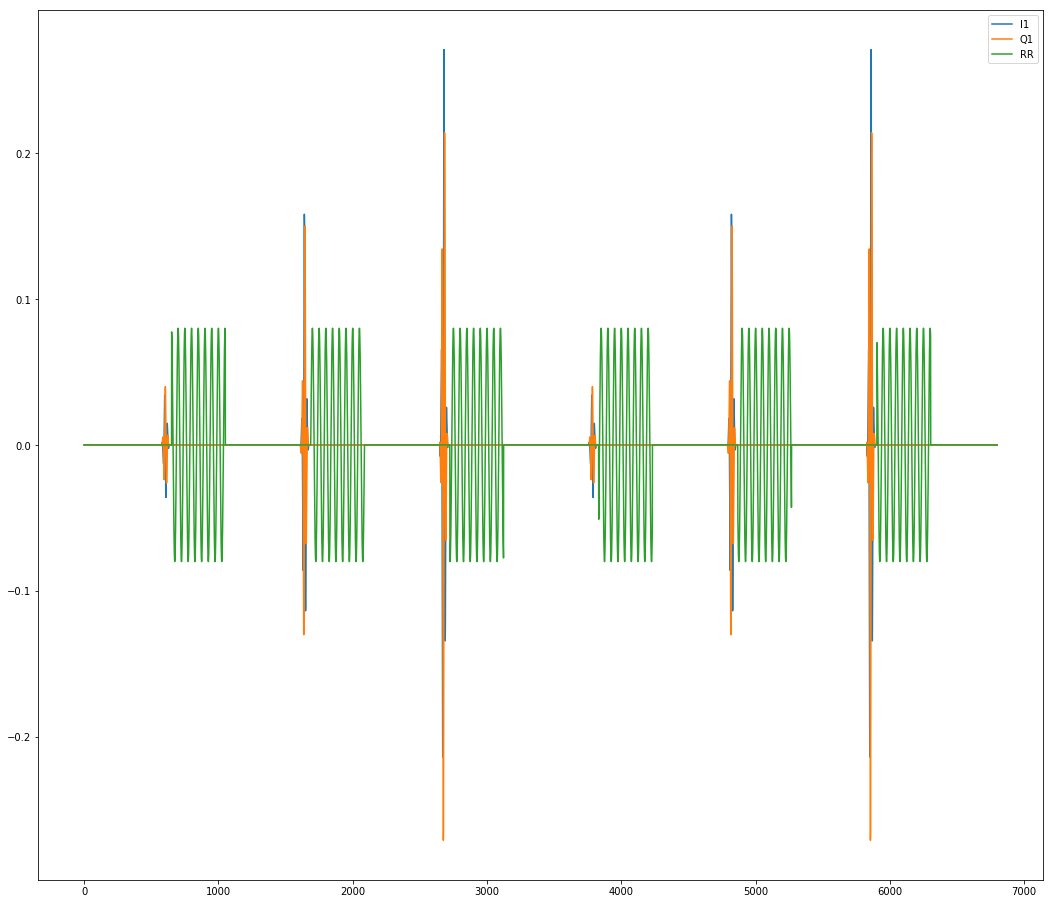

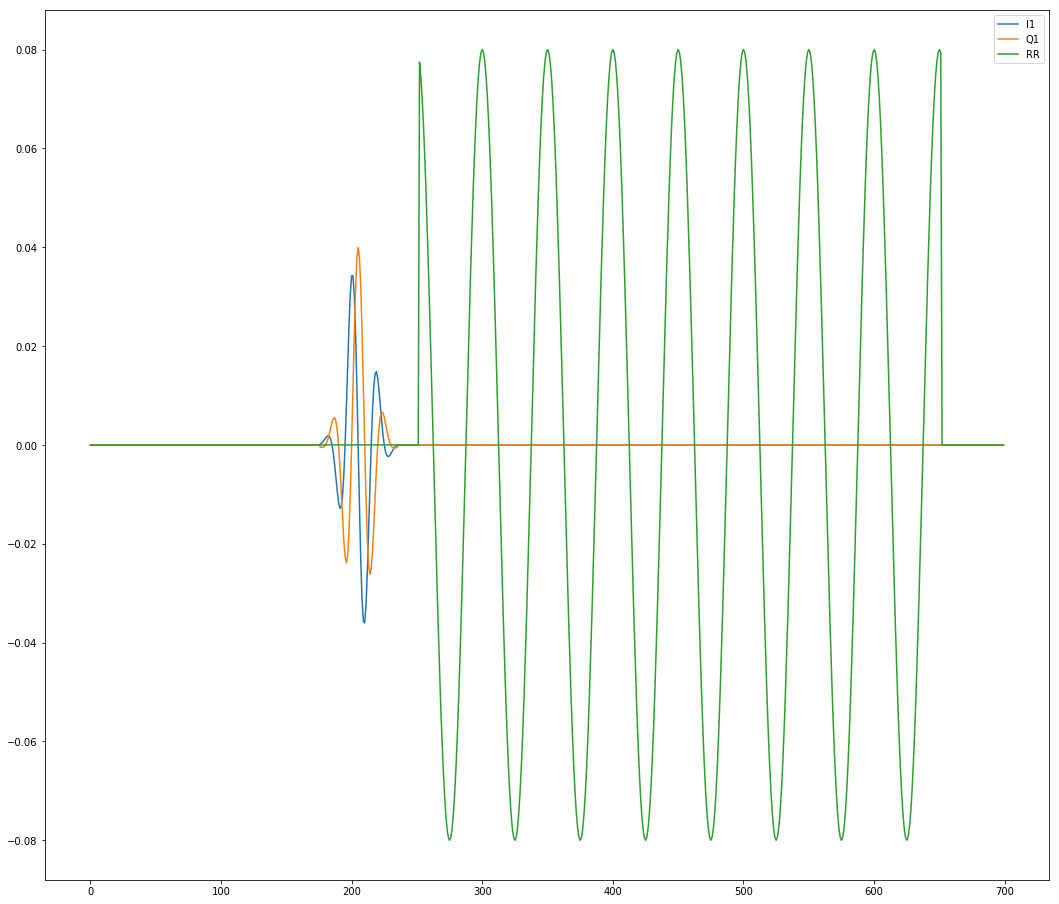

In [18]:
simConfigObj = SimulationConfig(1700)
job = qm.simulate(power_rabi, simConfigObj)
samples = job.get_simulated_samples()
I1 = samples.con1.analog['1']
Q1 = samples.con1.analog['2']
RR = samples.con1.analog['7']

# plot 1
plt.figure(figsize=(18, 16))
plt.plot(I1, label='I1')
plt.plot(Q1, label='Q1')
plt.plot(RR, label='RR')
plt.legend()

# plot 2
plt.figure(figsize=(18, 16))
plt.plot(I1[400:1100], label='I1')
plt.plot(Q1[400:1100], label='Q1')
plt.plot(RR[400:1100], label='RR')
plt.legend()


#### T1:

In [19]:
with program() as T1:
    
    n = declare(int)
    t = declare(int)
    I = declare(fixed)
    T = declare(int)
    
    with for_(n, 0, n < 2, n + 1):
        
        with for_(t, 4, t < 128, t + 50):
            
            assign(T, 300-t)
            wait(T, 'qubit1')
            play('pi', 'qubit1')
            wait(t, 'qubit1')
            align('qubit1', 'RR1')
            measure('readout', 'RR1', None, demod.full('Wc', I))
            save(I, 'I')
        

##### Test code:

2020-04-03 11:46:59,920 - qm - INFO - Flags: 
2020-04-03 11:46:59,922 - qm - INFO - Executing high level program
The free evolution times are: [1600, 2236, 1580]


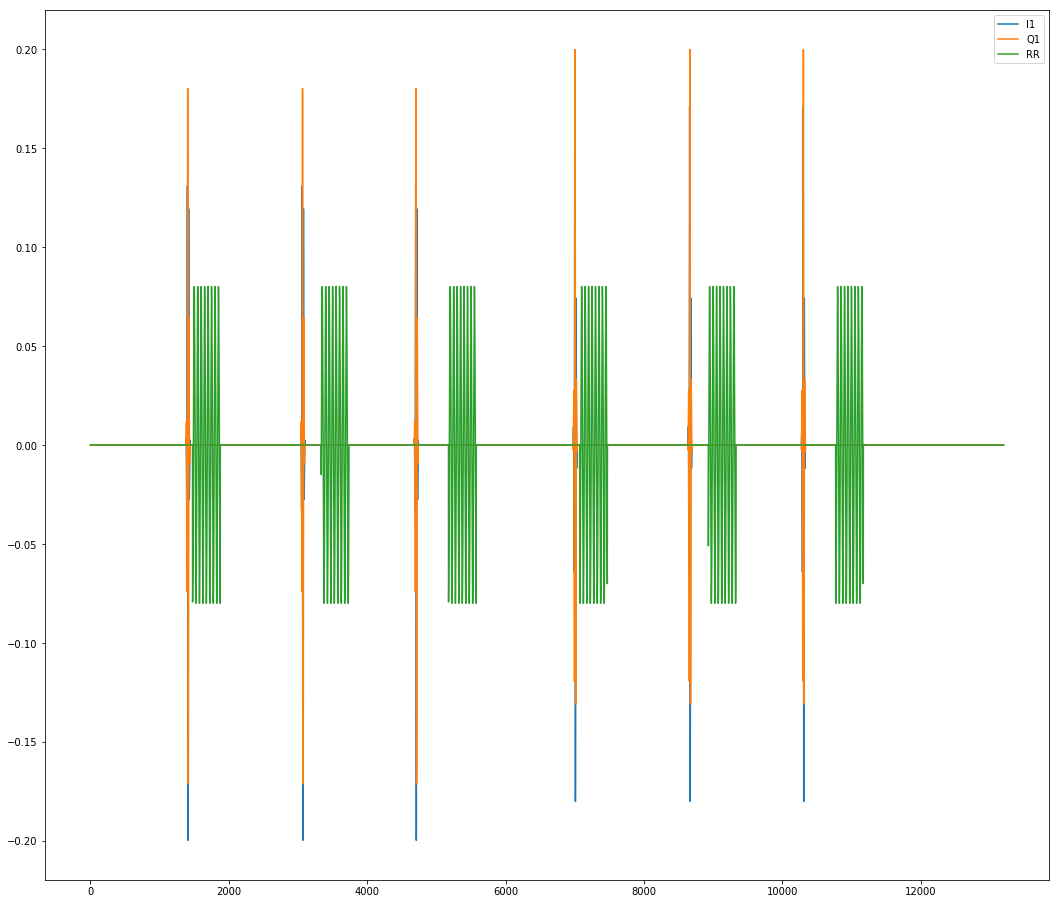

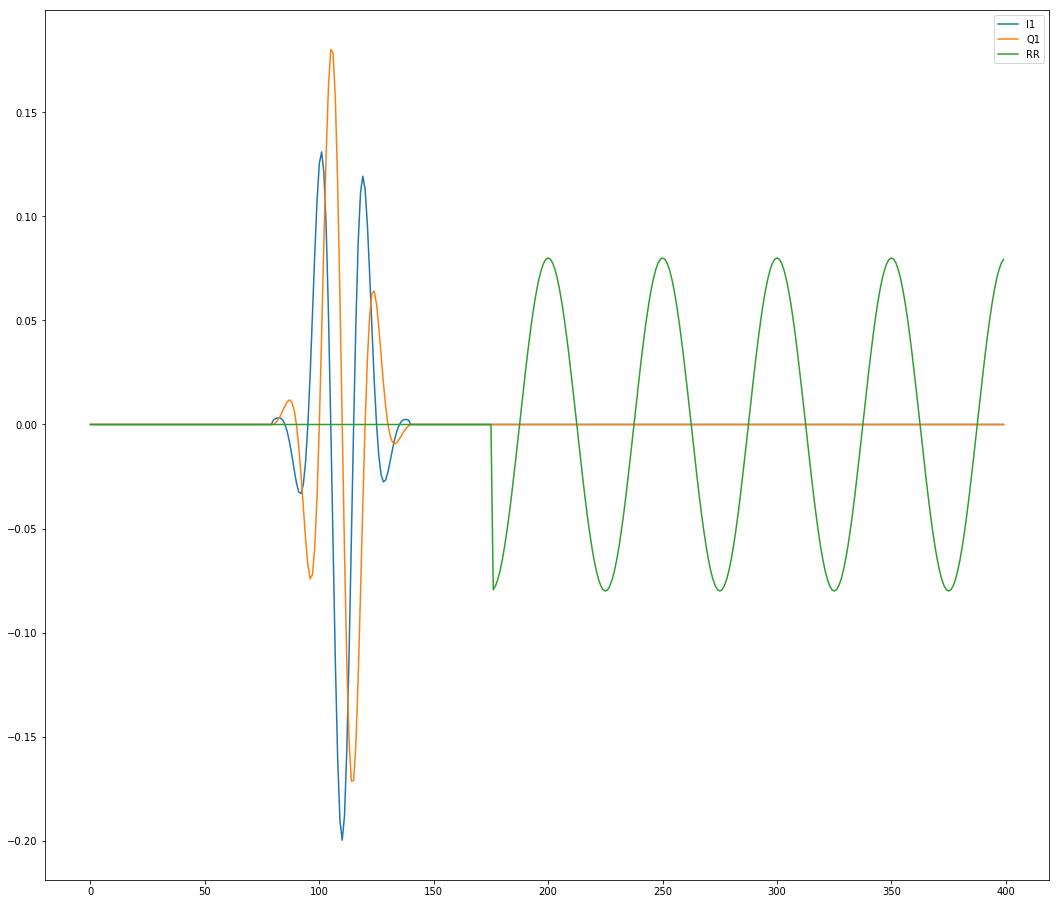

In [20]:
simConfigObj = SimulationConfig(3300)
job = qm.simulate(T1, simConfigObj)
samples = job.get_simulated_samples()
I1 = samples.con1.analog['1']
Q1 = samples.con1.analog['2']
RR = samples.con1.analog['7']

delays = find_waits(I1)[1::2]
print("The free evolution times are: {}".format(delays))
# plot 1
plt.figure(figsize=(18, 16))
plt.plot(I1, label='I1')
plt.plot(Q1, label='Q1')
plt.plot(RR, label='RR')
plt.legend()

# plot 2
plt.figure(figsize=(18, 16))
plt.plot(I1[1300:1700], label='I1')
plt.plot(Q1[1300:1700], label='Q1')
plt.plot(RR[1300:1700], label='RR')
plt.legend()

#### Spin-echo (with CPMG pulses):

In [21]:
T = 1200
max_cpmg = 3
pi_length = 60
v = []
for i in range(max_cpmg+1):
    d_ = round((T- i * pi_length)/(i+1)/4 -5)
    v.append((i, d_))

print(v)


with program() as spin_echo:
    
    p = declare(int)
    d = declare(int)
    i = declare(int)
    I = declare(fixed)
    n = declare(int)
    
    with for_(n, 0, n<2, n+1):
        
        with for_each_((p,d), v):
            
            wait(300, 'qubit1')
            play('pi/2', 'qubit1')
            z_rot(np.pi/2,'qubit1')
            wait(d, 'qubit1')
            with for_(i, 0, i < p, i + 1):
                play('pi', 'qubit1')
                wait(d, 'qubit1')
            z_rot(np.pi/2, 'qubit1')
            play('pi/2', 'qubit1')
            align('qubit1', 'RR1')
            measure('readout', 'RR1', None, demod.full('Wc', I))
            save(I, "I")

[(0, 295), (1, 138), (2, 85), (3, 59)]


##### Test code

2020-04-03 11:47:01,016 - qm - INFO - Flags: 
2020-04-03 11:47:01,017 - qm - INFO - Executing high level program


array([1260., 1264., 1260., 1264., 1260., 1264., 1260., 1264.])

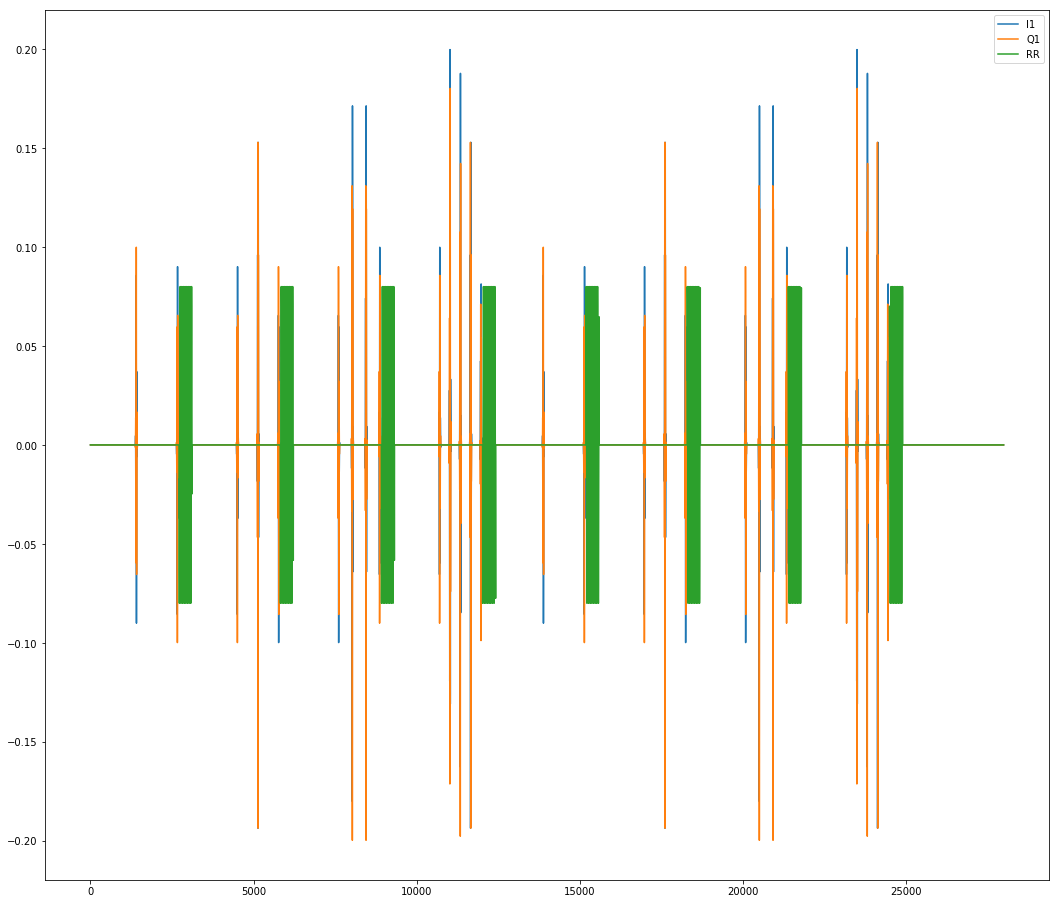

In [22]:
simConfigObj = SimulationConfig(7000, include_analog_waveforms=True)
job = qm.simulate(spin_echo, simConfigObj)
samples = job.get_simulated_samples()
I1 = samples.con1.analog['1']
Q1 = samples.con1.analog['2']
RR = samples.con1.analog['7']

plt.figure(figsize=(18, 16))
plt.plot(I1, label='I1')
plt.plot(Q1, label='Q1')
plt.plot(RR, label='RR')
plt.legend()

a = {qe: [{'name': i['name'], 'timestamp': i['timestamp']} for i in val] for qe, val in job.simulated_analog_waveforms()['elements'].items()}
np.diff([i['timestamp'] for i in a['qubit1'] if i['name']=='pi/2_wf1'])[::2]

#### Active reset

In [23]:
th = -0.1
with program() as active_reset:
    
    n = declare(int)
    Iref = declare(fixed)
    Qref = declare(fixed)
    I = declare(fixed)
    Q = declare(fixed)
    
    with for_(n, 0, n<5, n+1):
        
        measure('readout', 'RR1', None, demod.full('WI_opt', Iref), demod.full('WI_opt', Qref))
        with if_(Iref > th):
            play("pi", "qubit1")
        align("qubit1", "RR1")
        measure('readout', 'RR1', None, demod.full('WI_opt', I), demod.full('WQ_opt', Q))
        
        save(Iref, 'Iref')
        save(Qref, 'Qref')
        save(I, 'I')
        save(Q, 'Q')
        wait(200, "qubit1", "RR1")

##### Test code

2020-04-03 11:47:02,362 - qm - INFO - Flags: 
2020-04-03 11:47:02,364 - qm - INFO - Executing high level program


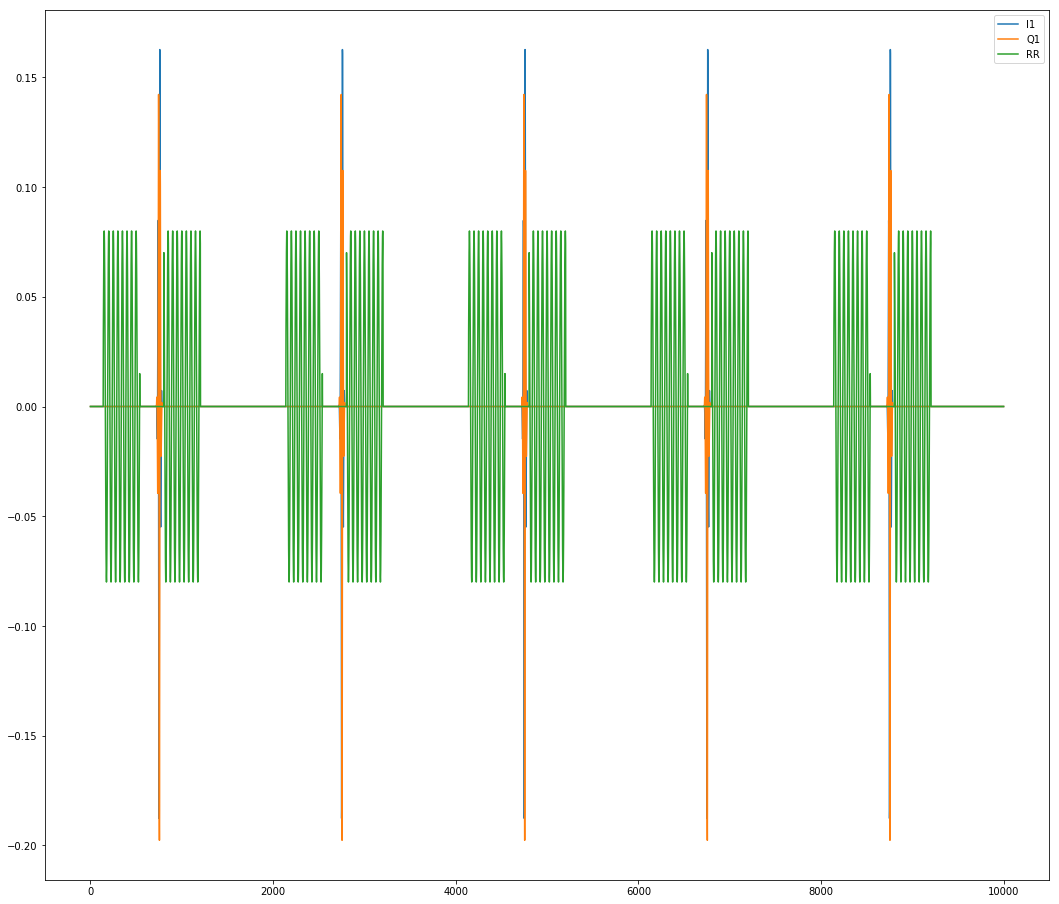

In [24]:
simConfigObj = SimulationConfig(2500, include_analog_waveforms=True)
job = qm.simulate(active_reset, simConfigObj)
samples = job.get_simulated_samples()
I1 = samples.con1.analog['1']
Q1 = samples.con1.analog['2']
RR = samples.con1.analog['7']

plt.figure(figsize=(18, 16))
plt.plot(I1, label='I1')
plt.plot(Q1, label='Q1')
plt.plot(RR, label='RR')
plt.legend()